# Preprocess Hige Data

---

Hige dataset (`../data/hige_mbon_response.mat`) contains **11 odors** (including empty): 
- 'vinegar'
- 'yeast'
- '2-heptanone'
- 'hexanol'
- 'octanol'
- 'mch'
- 'peppermint'
- 'ethanol'
- 'citronella'
- 'co2'
- 'empty'

Which were used to stimulate **16 MBON cell types/combinations**:
- 14 cell types
- 2 cell type combinations
- This covers 18 of the 21 MBON cell types.

Each of the stimuli was presented to each of the regions **5** times.

In [1]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.io import loadmat

from utils import greek_text_to_symbol, get_simple_name

%matplotlib inline

plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 12

sns.set_style("whitegrid",{"axes.edgecolor": "0",'grid.color': '0','font.family':'Arial'})
sns.set_context("notebook",font_scale=1.5)

DATA_DIR = Path('../data')

## Load data

### 1. Build a dictionary from the Matlab data

In [2]:
data = loadmat('../data/hige_mbon_response.mat')
x = data['Data']

ddict = {}
for i in range(17): 
    if x[0,0][i][0][0][1][0] not in ddict:
        ddict[x[0,0][i][0][0][1][0].replace("\\", '')] = x[0,0][i][0][0][0]

In [3]:
ddict

{'calyx': array([[ 2.64581243e+01,  1.80268559e+01,  5.20236468e+00,
          6.49289284e+00, -2.51470507e+00,  2.64174480e+00,
          8.54103899e+00,  9.62105665e+00,  6.15603843e-01,
         -1.78085467e+00,  2.62401141e+00],
        [ 2.34235951e+01,  1.13124958e+01,  1.08976798e-01,
         -3.06631992e+00,  1.81093572e-03,  3.79397361e-01,
          2.02729415e+00,  4.79221708e+00, -3.52294741e-01,
         -1.74458643e-01,  5.97445973e-01],
        [ 2.24243499e+01,  1.20411586e+01,  2.70220484e+00,
          3.68437168e+00, -5.96321355e-01,  2.58677747e+00,
          1.33120617e+00,  8.38866933e+00,  1.26593571e-01,
         -5.01651651e-01, -1.48901281e+00],
        [ 2.07715227e+01,  8.33728122e+00,  3.55488858e+00,
         -7.37769170e-02, -3.03112179e-01, -4.28889046e-01,
          6.34038013e-01,  5.72009493e+00, -3.98655666e-01,
          1.65368445e+00,  8.29220026e-02],
        [ 1.75632491e+01,  7.44900490e+00,  4.58678114e+00,
          6.49722422e-01, -6.906584

### 2. Build a dataframe

In [4]:
odors = ['vinegar', 'yeast', '2-heptanone', 'hexanol', 'octanol', 'mch', 'peppermint', 'ethanol', 'citronella', 'co2', 'empty']
raw_data = pd.DataFrame(columns = ['id', 'stimulus', 'dF/F'])

for lobe in ddict.keys():
    # 11 stimuli, 5 trials, 1 cell type
    y = pd.DataFrame.from_dict(ddict[lobe])
    y.columns = odors
    y.index = [''.join([lobe, "_", 'fly', str(i)]) for i in range(5)]
    y = y.stack().reset_index()
    y.columns = ['id', 'stimulus', 'dF/F']
    
    raw_data = pd.concat([raw_data, y])


raw_data[['MBON cell type', 'fly_id']] = raw_data['id'].str.split('_', 1, expand=True)

In [5]:
raw_data

,id,stimulus,dF/F,MBON cell type,fly_id
0,calyx_fly0,vinegar,26.458124,calyx,fly0
1,calyx_fly0,yeast,18.026856,calyx,fly0
2,calyx_fly0,2-heptanone,5.202365,calyx,fly0
3,calyx_fly0,hexanol,6.492893,calyx,fly0
4,calyx_fly0,octanol,-2.514705,calyx,fly0
...,...,...,...,...,...
50,alpha1_fly4,peppermint,7.261187,alpha1,fly4
51,alpha1_fly4,ethanol,20.986401,alpha1,fly4
52,alpha1_fly4,citronella,0.716510,alpha1,fly4
53,alpha1_fly4,co2,3.464856,alpha1,fly4


## Process Data

### 1. Clean the data:

First remove unnecesary information:
- Removing the activity in the Calyx (not part of the MB under investigation)
- Remove the `empty` and `co2` stimulus data (not used by Siju)

In [6]:
# Do some cleaning
raw_data = raw_data[raw_data['MBON cell type'] != 'calyx']

uncommon_stimuli = ['empty', 'co2']
raw_data = raw_data[~raw_data["stimulus"].isin(uncommon_stimuli)]

print(raw_data.shape)
raw_data.head()

(720, 5)


,id,stimulus,dF/F,MBON cell type,fly_id
0,gamma1pedc_fly0,vinegar,66.213579,gamma1pedc,fly0
1,gamma1pedc_fly0,yeast,65.091995,gamma1pedc,fly0
2,gamma1pedc_fly0,2-heptanone,46.239205,gamma1pedc,fly0
3,gamma1pedc_fly0,hexanol,52.249343,gamma1pedc,fly0
4,gamma1pedc_fly0,octanol,5.743157,gamma1pedc,fly0


### 2. Understanding cell types and combinations

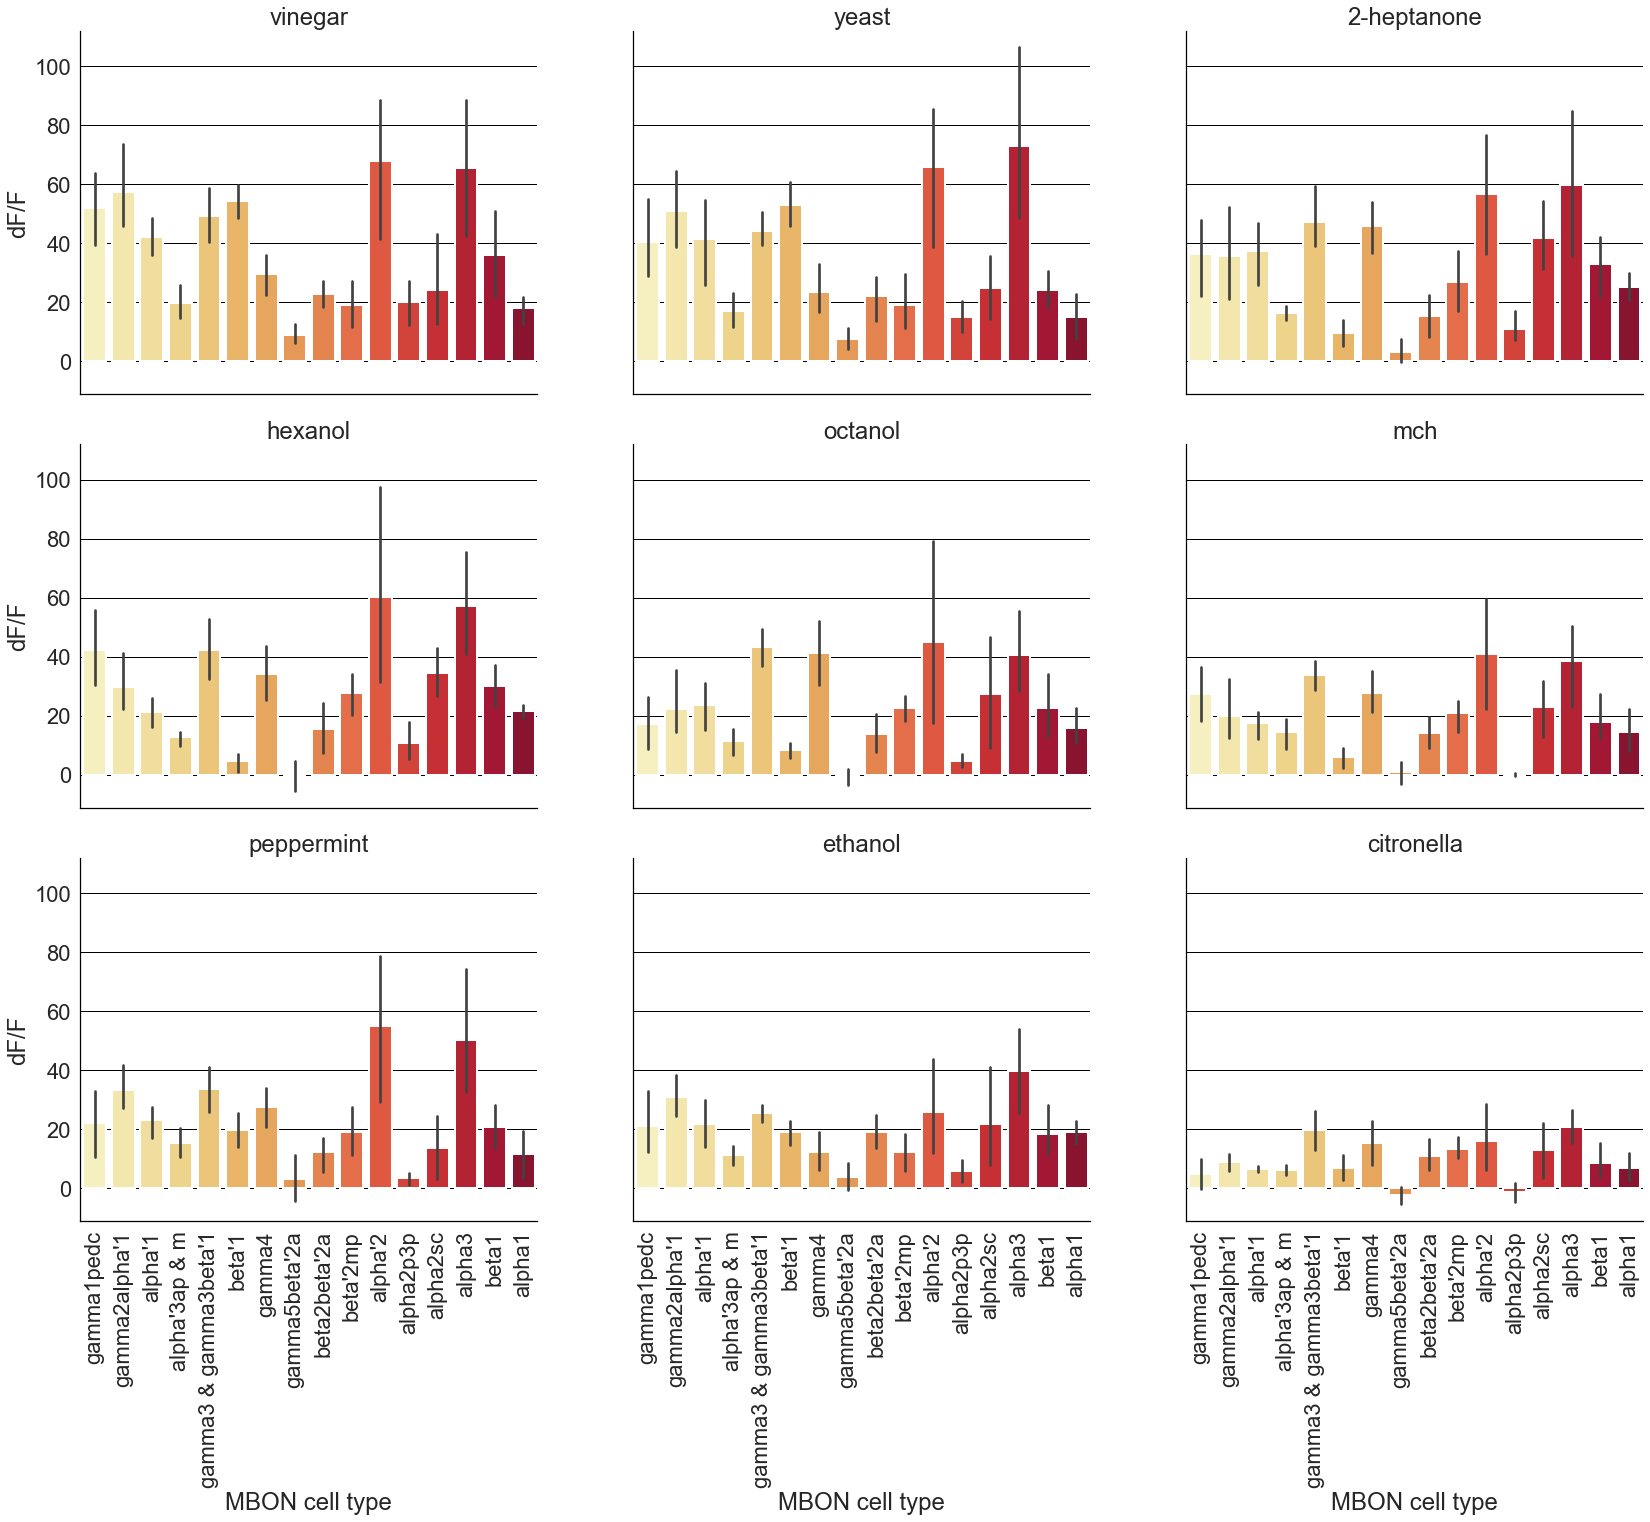

In [7]:
# Plot cell combination/type activity 
# Do the combinations display substancially stronger activation?

plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 16
sns.set_context("notebook",font_scale=2)


b = sns.catplot(
    x="MBON cell type", 
    y="dF/F", 
    col="stimulus", 
    col_wrap=3, 
    data=raw_data, 
    linewidth=2, 
    kind="bar",
    palette='YlOrRd',
    height=6, 
    aspect=1.3
)
b.set_titles("{col_name}") 
b.set_xticklabels(rotation=90)
plt.savefig('hige-activity-per-stim.png')

In [8]:
mbon_types_and_combinations = raw_data['MBON cell type'].unique()
mbon_combinations = [x for x in mbon_types_and_combinations if '&' in x]
mbon_types = list(set(mbon_combinations) ^ set(mbon_types_and_combinations))

print(f"Number of mbon_types_and_combinations: {len(mbon_types_and_combinations)}")
print(f"Number of mbon_types: {len(mbon_types)}")
print(f"Number of mbon_combinations: {len(mbon_combinations)}")
print(f"mbon_combinations: {mbon_combinations}")

Number of mbon_types_and_combinations: 16
Number of mbon_types: 14
Number of mbon_combinations: 2
mbon_combinations: ["alpha'3ap & m", "gamma3 & gamma3beta'1"]


In [9]:
# Sanity check on #experiments per stimulus
number_trials_per_stimulus = raw_data['stimulus'].value_counts()/mbon_types_and_combinations.size
number_trials_per_stimulus = number_trials_per_stimulus.to_frame()
number_trials_per_stimulus.columns = ['experiment count']
number_trials_per_stimulus

,experiment count
vinegar,5.0
yeast,5.0
2-heptanone,5.0
hexanol,5.0
octanol,5.0
mch,5.0
peppermint,5.0
ethanol,5.0
citronella,5.0


### 3. Split combinations into individual cell types

The Hige data is made up of 16 types or combinations of types of MBONs. This covers 18/21 MBON cell types.

__ASSUMPTION__: each cell type in a combination has the same activity as the combination.
- `gamma3 & gamma3beta'1` => `[gamma3, gamma3beta'1]`
- `alpha'3ap & m` => `[alpha'3ap, alpha'3m]`



In [10]:
def replace_combination(df:pd.DataFrame, combination:str, cell_types:list) -> pd.DataFrame:
    '''
    Replaces the combination readings by duplicating its rows for each
    cell type in the combination (not in place).
    TODO: Try reduce the number of copies made and remove for loops..
    '''
    for cell_type in cell_types:
        to_insert = df[df["MBON cell type"] == combination].copy()
        to_insert['MBON cell type'] = cell_type
        df = df.append(to_insert)
    
    df = df[~(df["MBON cell type"] == combination)]
    
    return df

In [11]:
print(f'Before: {raw_data["MBON cell type"].unique()}')

print(raw_data.shape)
raw_data = replace_combination(raw_data, "alpha'3ap & m", ["alpha'3ap", "alpha'3m"])
print(raw_data.shape)
raw_data = replace_combination(raw_data, "gamma3 & gamma3beta'1", ["gamma3", "gamma3beta'1"])
print(raw_data.shape)
      
print(f'After: {raw_data["MBON cell type"].unique()}')

Before: ['gamma1pedc' "gamma2alpha'1" "alpha'1" "alpha'3ap & m"
 "gamma3 & gamma3beta'1" "beta'1" 'gamma4' "gamma5beta'2a" "beta2beta'2a"
 "beta'2mp" "alpha'2" 'alpha2p3p' 'alpha2sc' 'alpha3' 'beta1' 'alpha1']
(720, 5)
(765, 5)
(810, 5)
After: ['gamma1pedc' "gamma2alpha'1" "alpha'1" "beta'1" 'gamma4' "gamma5beta'2a"
 "beta2beta'2a" "beta'2mp" "alpha'2" 'alpha2p3p' 'alpha2sc' 'alpha3'
 'beta1' 'alpha1' "alpha'3ap" "alpha'3m" 'gamma3' "gamma3beta'1"]


In [12]:
raw_data = raw_data.sort_values(by=["MBON cell type", "stimulus"])
raw_data.head(20)

,id,stimulus,dF/F,MBON cell type,fly_id
2,alpha'1_fly0,2-heptanone,47.942858,alpha'1,fly0
13,alpha'1_fly1,2-heptanone,50.515459,alpha'1,fly1
24,alpha'1_fly2,2-heptanone,32.195216,alpha'1,fly2
35,alpha'1_fly3,2-heptanone,40.542121,alpha'1,fly3
46,alpha'1_fly4,2-heptanone,15.532834,alpha'1,fly4
8,alpha'1_fly0,citronella,6.450651,alpha'1,fly0
19,alpha'1_fly1,citronella,7.304610,alpha'1,fly1
30,alpha'1_fly2,citronella,7.545683,alpha'1,fly2
41,alpha'1_fly3,citronella,7.792920,alpha'1,fly3
52,alpha'1_fly4,citronella,4.272539,alpha'1,fly4


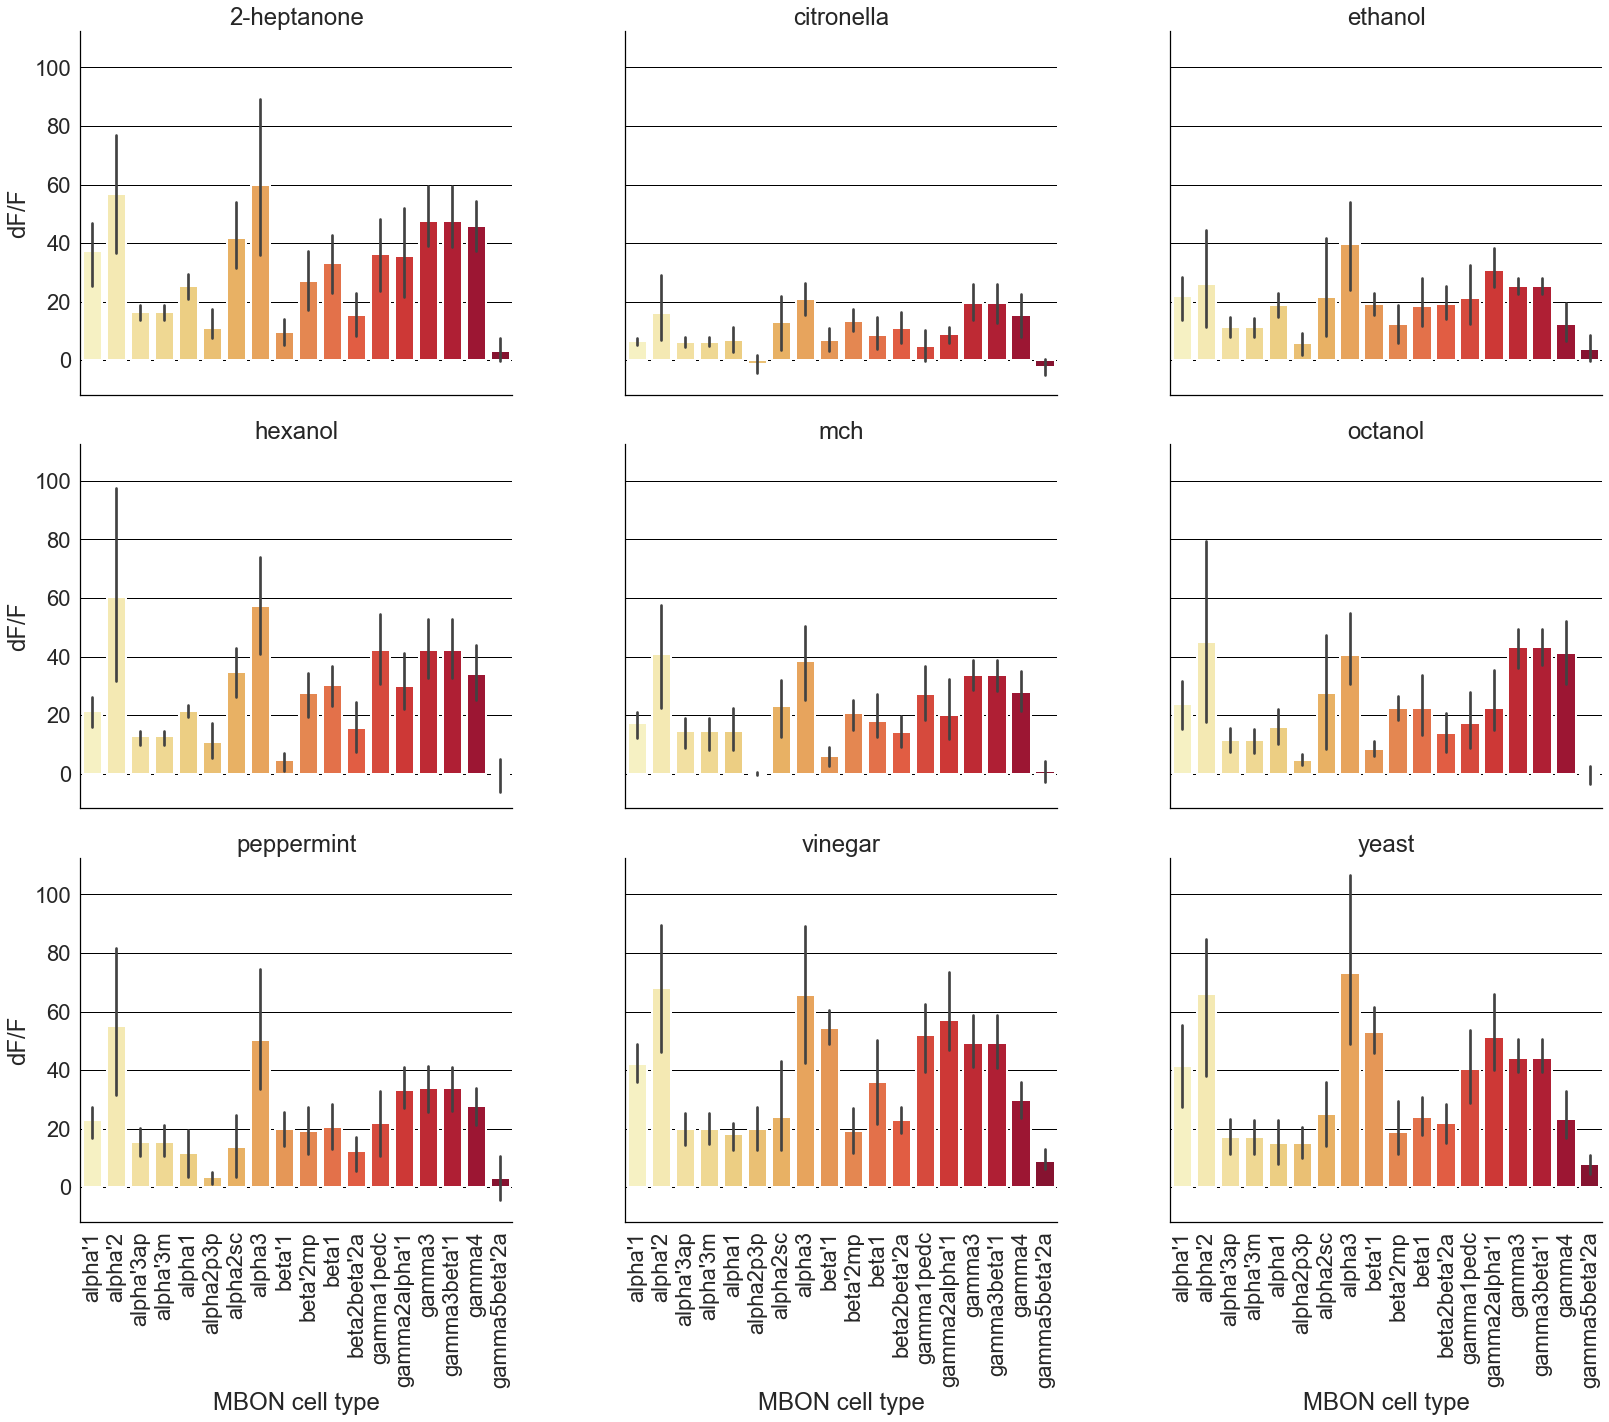

In [13]:
b = sns.catplot(
    x="MBON cell type", 
    y="dF/F", 
    col="stimulus", 
    col_wrap=3, 
    data=raw_data, 
    linewidth=2, 
    kind="bar",
    palette='YlOrRd',
    height=6, 
    aspect=1.3
)
b.set_titles("{col_name}") 
b.set_xticklabels(rotation=90)

## Estimate MBON lobe activity from MBON cell activity

In [14]:
df = raw_data.copy(deep=True)
df

,id,stimulus,dF/F,MBON cell type,fly_id
2,alpha'1_fly0,2-heptanone,47.942858,alpha'1,fly0
13,alpha'1_fly1,2-heptanone,50.515459,alpha'1,fly1
24,alpha'1_fly2,2-heptanone,32.195216,alpha'1,fly2
35,alpha'1_fly3,2-heptanone,40.542121,alpha'1,fly3
46,alpha'1_fly4,2-heptanone,15.532834,alpha'1,fly4
...,...,...,...,...,...
1,gamma5beta'2a_fly0,yeast,7.070756,gamma5beta'2a,fly0
12,gamma5beta'2a_fly1,yeast,13.723368,gamma5beta'2a,fly1
23,gamma5beta'2a_fly2,yeast,6.913971,gamma5beta'2a,fly2
34,gamma5beta'2a_fly3,yeast,9.203812,gamma5beta'2a,fly3


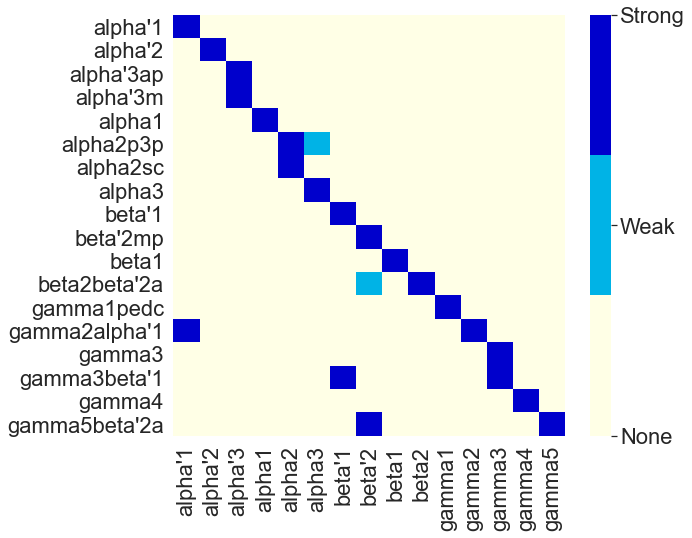

In [15]:
from matplotlib.colors import LinearSegmentedColormap

cell_types = raw_data['MBON cell type'].unique()
lobes = []

# Build a weight matrix from Aso 2014, Fig 12 A
W = pd.DataFrame(index = cell_types, columns=lobes)
W.loc["alpha'1", "alpha'1"] = 1.0
W.loc["alpha'2", "alpha'2"] = 1.0
W.loc["alpha'3ap", "alpha'3"] = 1.0
W.loc["alpha'3m", "alpha'3"] = 1.0
W.loc["alpha1", "alpha1"] = 1.0
W.loc["alpha2p3p", "alpha2"] = 1.0
W.loc["alpha2p3p", "alpha3"] = 0.5
W.loc["alpha2sc", "alpha2"] = 1.0
W.loc["alpha3", "alpha3"] = 1.0
W.loc["beta'1", "beta'1"] = 1.0
W.loc["beta'2mp", "beta'2"] = 1.0
W.loc["beta1", "beta1"] = 1.0
W.loc["beta2beta'2a", "beta2"] = 1.0
W.loc["beta2beta'2a", "beta'2"] = 0.5
W.loc["gamma1pedc", "gamma1"] = 1.0
W.loc["gamma2alpha'1", "gamma2"] = 1.0
W.loc["gamma2alpha'1", "alpha'1"] = 1.0
W.loc["gamma3", "gamma3"] = 1.0
W.loc["gamma3beta'1", "gamma3"] = 1.0
W.loc["gamma3beta'1", "beta'1"] = 1.0
W.loc["gamma4", "gamma4"] = 1.0
W.loc["gamma5beta'2a", "gamma5"] = 1.0
W.loc["gamma5beta'2a", "beta'2"] = 1.0

W = W.sort_index(axis=1)
W = W.fillna(0)

plt.figure(figsize=(10,8))
myColors = ((1, 1, 0.9, 1.0), (0.0, 0.7, 0.9, 1.0), (0.0, 0.0, 0.8, 1.0))
cmap = LinearSegmentedColormap.from_list('Custom', myColors, len(myColors))
ax = sns.heatmap(W, cmap=cmap, xticklabels=True, yticklabels=True)
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([0, 0.5, 1])
colorbar.set_ticklabels(['None', 'Weak', 'Strong'])
plt.tight_layout()
plt.savefig('convert-cell-to-compartment.png')
plt.show()

In [16]:
final_df = pd.DataFrame(columns=['dF/F', 'lobe'])

for lobe in W.columns:    
    # Get relevent weights
    lobe_W = W[W[lobe] > 0][lobe]

    # Get a dataframe containing all the cell types contributing to the activity in lobe <lobe>
    temp_df = df[df["MBON cell type"].isin(set(W[W[lobe] > 0].index))].copy()

    # Build a dataframe for <lobe> containing relevent cell types and corresponding weights
    for cell_type in lobe_W.index: 
        temp_df.loc[temp_df["MBON cell type"] == cell_type, "weight"] = lobe_W[cell_type]

    # Apply weighted average and set lobe column 
    w_av_activity = temp_df.groupby(["stimulus", "fly_id"]).apply(
        lambda x: np.average(x["dF/F"], weights=x["weight"])
    ).to_frame()
    
    w_av_activity.columns = ['dF/F']
    w_av_activity['lobe'] = lobe
    
    # Append to final dataframe    
    final_df = final_df.append(w_av_activity)
    
    del temp_df, w_av_activity


final_df.reset_index(level=0, inplace=True)

# Relabel columns
final_df.columns = ['stimulus', 'MBON dF/F', 'lobe']

# Split the tuple column
final_df[['stimulus', 'fly_id']] = pd.DataFrame(final_df['stimulus'].tolist(), index=final_df.index)

# TODO remove this step by being smarter at an earlier stage
final_df['id'] = final_df['stimulus'] + '_' + final_df['fly_id']

# Convert text lobe labels to greek letters
# final_df['lobe'] = final_df['lobe'].apply(greek_text_to_symbol)

final_df

,stimulus,MBON dF/F,lobe,fly_id,id
0,2-heptanone,57.014634,alpha'1,fly0,2-heptanone_fly0
1,2-heptanone,44.168362,alpha'1,fly1,2-heptanone_fly1
2,2-heptanone,30.958356,alpha'1,fly2,2-heptanone_fly2
3,2-heptanone,36.248176,alpha'1,fly3,2-heptanone_fly3
4,2-heptanone,14.150340,alpha'1,fly4,2-heptanone_fly4
...,...,...,...,...,...
670,yeast,7.070756,gamma5,fly0,yeast_fly0
671,yeast,13.723368,gamma5,fly1,yeast_fly1
672,yeast,6.913971,gamma5,fly2,yeast_fly2
673,yeast,9.203812,gamma5,fly3,yeast_fly3


In [17]:
pivot = final_df.pivot_table(index='id', columns='lobe')
pivot['stimulus'] = pivot.index
pivot['stimulus'] = pivot['stimulus'].str.split('_', 1, expand=True)[0]
pivot['stimulus'] = pivot['stimulus'].apply(get_simple_name)

pivot

MBON dF/F                                               \
lobe                alpha'1     alpha'2    alpha'3     alpha1     alpha2   
id                                                                         
2-heptanone_fly0  57.014634   53.449785  14.488461  31.733999  35.150185   
2-heptanone_fly1  44.168362   91.255851  17.765559  29.395413  28.380873   
2-heptanone_fly2  30.958356   67.175713  19.834570  25.548454  31.033140   
2-heptanone_fly3  36.248176   50.087333  18.659880  21.263302  20.912131   
2-heptanone_fly4  14.150340   21.817438  11.888643  18.037705  17.063540   
citronella_fly0    9.145744   13.330172   6.479354  15.588128  10.570066   
citronella_fly1    7.703690   40.631430   7.078989   4.574127   5.869578   
citronella_fly2   10.451870    6.608032   4.313396   9.567218   9.765735   
citronella_fly3    6.220579   17.026007   9.226547   4.307164   4.542118   
citronella_fly4    5.210402    3.429533   4.081137   0.716510  -1.266533   
ethanol_fly0      40.102149   25.657454  17.480856  20.465026   9.073940   
ethanol_fly1      22.866154   61.781223  13.698329  26.013817  15.665248   
ethanol_fly2      27.873369   22.945716   8.849489  12.856040  29.543897   
ethanol_fly3      25.487867   11.833650  10.470424  14.655109  10.399776   
ethanol_fly4      15.673262    7.297610   5.484531  20.986401   4.300968   
hexanol_fly0      39.847909   41.145887  14.705350  23.274065  20.036128   
hexanol_fly1      27.206782   66.702770  13.372852  24.763076  22.570431   
hexanol_fly2      24.016075   42.232322  14.424108  18.086818  29.817861   
hexanol_fly3      21.425379  134.467354  14.518282  22.157297  23.633270   
hexanol_fly4      15.676100   16.742987   6.935282  19.389451  17.438191   
mch_fly0          32.210371   34.424121  17.065013  28.960961  19.161200   
mch_fly1          13.979124   54.990296  21.624421  13.894501  13.559433   
mch_fly2          17.452011   37.994483  12.165062  10.785901  13.613714   
mch_fly3          17.575320   69.835747  17.774210   3.854927   7.668850   
mch_fly4          12.788809    7.599479   3.963068  15.084144   3.530460   
octanol_fly0      32.734149   20.451610   9.785424  28.479226  27.371883   
octanol_fly1      23.932890   62.887743  10.130735  11.817334  30.751806   
octanol_fly2      23.847616   25.383854  17.755241  13.895971   3.183700   
octanol_fly3      21.297618  104.620888  15.212139  16.832599   7.290940   
octanol_fly4      13.119413   11.135124   4.209651   7.907668  12.098724   
peppermint_fly0   36.998941   54.222512  12.259927  25.031783  11.211121   
peppermint_fly1   24.764202   92.580709  18.543498  19.566874  19.956960   
peppermint_fly2   31.770170   38.928485  12.757664  -2.451519   5.835617   
peppermint_fly3   25.345241   76.979786  25.147513   8.614913   5.655734   
peppermint_fly4   22.341381   12.440939   7.948223   7.261187   0.357082   
vinegar_fly0      70.111052  100.075546  29.086642  19.029277  25.869998   
vinegar_fly1      53.921201   84.423853  25.370498  20.798814  19.889108   
vinegar_fly2      45.073667   79.577011  17.098331   7.008783  39.681230   
vinegar_fly3      41.510561   51.669740  16.758226  22.934762  15.906727   
vinegar_fly4      38.063387   23.720695  11.146067  21.351970   8.958956   
yeast_fly0        70.470493   78.547215  27.788022  26.436362  26.472335   
yeast_fly1        45.645128   92.212557  15.872347  23.228980  27.787981   
yeast_fly2        46.970257   73.130669   9.117605   2.941037  22.518122   
yeast_fly3        37.293780   73.249547  21.880201   8.343094  15.382588   
yeast_fly4        31.013675   12.466037  11.203325  15.071459   8.316080   

                                                                         \
lobe                 alpha3     beta'1     beta'2      beta1      beta2   
id                                                                        
2-heptanone_fly0  50.098322  29.570272  25.684328  34.010916  11.951235   
2-heptanone_fly1  21.858113  24.830531  16.444911  43.192486  27.9043

In [18]:
# do a check with the averaged pivot table

pivot.loc[pivot['stimulus'] == 'ethanol' ]["MBON dF/F"]["alpha'2"].mean()

25.9031303954676

### Save the dataset

In [19]:
pivot.to_pickle(DATA_DIR / 'hige-cleaned-expanded-pivot.pkl')

In [20]:
pivot.shape

(45, 16)